In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import mysql.connector
import csv
import json

In [3]:
# loading the file
csv_file = "data/Crimes_2001_to_Present.csv"
df = pd.read_csv(csv_file)

# Analysis of Chicago crime data from 2001 to 2023
In this project, we intend to analize the data about crimes committed in the city of Chicago. First we are going to perform an Exploratory Data Analysis to get to know better our dataset, insert the data in the database, make transformations and gather insights.

In this dataset there is a big amount of data, and during the practice there were some problems with the time that the code spent to upload the whole dataset to the MySQL db. That's why for this EDA we selected the 0.01% of the rows randomly. 

In [4]:
# taking a random sample, random state is the seed
df = df.sample(frac=0.01, random_state=42)

In [4]:
df.shape

(78468, 22)

##### First, looking at the shape of our dataframe derived from the csv file, we can see that we are dealing with a dataset of 78468 rows and 22 columns.

In [5]:
df.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
3800619,3370972,HK420396,06/09/2004 08:00:00 AM,009XX W BARRY AVE,0620,BURGLARY,UNLAWFUL ENTRY,APARTMENT,False,False,...,44.0,6.0,05,1169267.0,1920768.0,2004,02/28/2018 03:56:25 PM,41.938102,-87.653316,"(41.938101906, -87.653315529)"
3699450,3242755,HK264216,03/26/2004 05:39:00 PM,015XX E 67TH ST,1310,CRIMINAL DAMAGE,TO PROPERTY,RESIDENCE PORCH/HALLWAY,False,False,...,5.0,42.0,14,1187565.0,1860868.0,2004,02/28/2018 03:56:25 PM,41.773316,-87.587979,"(41.773315666, -87.587978676)"
2192643,12931480,JF521087,12/21/2022 02:00:00 PM,107XX S HOXIE AVE,2825,OTHER OFFENSE,HARASSMENT BY TELEPHONE,APARTMENT,False,True,...,10.0,51.0,26,1195226.0,1834222.0,2022,01/03/2023 03:46:28 PM,41.700011,-87.560773,"(41.700011165, -87.560772612)"
1455339,11783693,JC379911,08/05/2019 04:49:00 PM,004XX E 111TH ST,0810,THEFT,OVER $500,SIDEWALK,True,False,...,9.0,49.0,06,1180966.0,1831449.0,2019,08/12/2019 04:17:08 PM,41.692741,-87.613071,"(41.692740831, -87.613071265)"
4724231,4842490,HM455914,06/20/2006 03:00:00 PM,003XX E 50TH ST,0890,THEFT,FROM BUILDING,OTHER,False,False,...,3.0,38.0,06,1179472.0,1871948.0,2006,02/28/2018 03:56:25 PM,41.803909,-87.617307,"(41.803908881, -87.617307147)"


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 78468 entries, 3800619 to 5929066
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID                    78468 non-null  int64  
 1   Case Number           78468 non-null  object 
 2   Date                  78468 non-null  object 
 3   Block                 78468 non-null  object 
 4   IUCR                  78468 non-null  object 
 5   Primary Type          78468 non-null  object 
 6   Description           78468 non-null  object 
 7   Location Description  78366 non-null  object 
 8   Arrest                78468 non-null  bool   
 9   Domestic              78468 non-null  bool   
 10  Beat                  78468 non-null  int64  
 11  District              78468 non-null  float64
 12  Ward                  72171 non-null  float64
 13  Community Area        72186 non-null  float64
 14  FBI Code              78468 non-null  object 
 15  X Coordinate    

##### These are the data types, the date and updated_on columns are not recognized as a 'datetime' data type

In [7]:
df.isnull().sum()

ID                         0
Case Number                0
Date                       0
Block                      0
IUCR                       0
Primary Type               0
Description                0
Location Description     102
Arrest                     0
Domestic                   0
Beat                       0
District                   0
Ward                    6297
Community Area          6282
FBI Code                   0
X Coordinate             872
Y Coordinate             872
Year                       0
Updated On                 0
Latitude                 872
Longitude                872
Location                 872
dtype: int64

##### Now we are looking at the number of null values in each column. This will help us determine which columns we are going to work with later on. Let's keep in mind that Ward an Community Area have a considerable amount of null values, which makes district a better option for analysis.

In [8]:
df.nunique()

ID                      78468
Case Number             78468
Date                    75709
Block                   24331
IUCR                      318
Primary Type               31
Description               383
Location Description      153
Arrest                      2
Domestic                    2
Beat                      302
District                   23
Ward                       50
Community Area             77
FBI Code                   26
X Coordinate            35517
Y Coordinate            43443
Year                       23
Updated On               2297
Latitude                59133
Longitude               59135
Location                59143
dtype: int64

# Transforming data before inserting in MySQL

##### As it was stated before, we need to alter the data to insert it into the database later. First, we will modify the format of the date columns and fill null values, and then we are going to change the names of the columns.

In [5]:
# turning date column into datetime to extract the time and create the time column
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y %I:%M:%S %p')
df['Time'] = df['Date'].apply(lambda x: x.time())

# changing updated_on format
df['Updated On'] = pd.to_datetime(df['Updated On'], format='%m/%d/%Y %I:%M:%S %p')

# taking just the date part, converting into dtype object
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y %I:%M:%S %p').dt.date

# replacing nulls
df = df.fillna({'Location Description': 'null', 'Ward': 0, 'Community Area': 0, 'X Coordinate': 0,'Y Coordinate': 0})

# cambiar el tipo de dato de la columna distrito

cols = ['District', 'Arrest', 'Domestic', 'Ward', 'Community Area', 'X Coordinate', 'Y Coordinate']
df[cols] = df[cols].astype(int)

move_time = df.pop('Time')
df.insert(3,'Time', move_time)

df.head()

,ID,Case Number,Date,Time,Block,IUCR,Primary Type,Description,Location Description,Arrest,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
3800619,3370972,HK420396,2004-06-09,08:00:00,009XX W BARRY AVE,0620,BURGLARY,UNLAWFUL ENTRY,APARTMENT,0,...,44,6,05,1169267,1920768,2004,2018-02-28 15:56:25,41.938102,-87.653316,"(41.938101906, -87.653315529)"
3699450,3242755,HK264216,2004-03-26,17:39:00,015XX E 67TH ST,1310,CRIMINAL DAMAGE,TO PROPERTY,RESIDENCE PORCH/HALLWAY,0,...,5,42,14,1187565,1860868,2004,2018-02-28 15:56:25,41.773316,-87.587979,"(41.773315666, -87.587978676)"
2192643,12931480,JF521087,2022-12-21,14:00:00,107XX S HOXIE AVE,2825,OTHER OFFENSE,HARASSMENT BY TELEPHONE,APARTMENT,0,...,10,51,26,1195226,1834222,2022,2023-01-03 15:46:28,41.700011,-87.560773,"(41.700011165, -87.560772612)"
1455339,11783693,JC379911,2019-08-05,16:49:00,004XX E 111TH ST,0810,THEFT,OVER $500,SIDEWALK,1,...,9,49,06,1180966,1831449,2019,2019-08-12 16:17:08,41.692741,-87.613071,"(41.692740831, -87.613071265)"
4724231,4842490,HM455914,2006-06-20,15:00:00,003XX E 50TH ST,0890,THEFT,FROM BUILDING,OTHER,0,...,3,38,06,1179472,1871948,2006,2018-02-28 15:56:25,41.803909,-87.617307,"(41.803908881, -87.617307147)"


In [6]:
df.columns = ["id","case_number","date", "time", "block","iucr","primary_type","description","location_desc","arrest","domestic","beat","district","ward", "community_area", "fbi_code", "x_coord",
       "y_coord","year","updated_on","latitude","longitude", "location"]
df.columns

Index(['id', 'case_number', 'date', 'time', 'block', 'iucr', 'primary_type',
       'description', 'location_desc', 'arrest', 'domestic', 'beat',
       'district', 'ward', 'community_area', 'fbi_code', 'x_coord', 'y_coord',
       'year', 'updated_on', 'latitude', 'longitude', 'location'],
      dtype='object')

##### After changing the names of the columns, we have to modify the "location" column to insert it in MySQL as a POINT coordinate. The corresponding format is: "POINT(latitude longitude)", and null values are not supported in this data type, so we are going to do this transformation, and then delete the rows with null values in location. 

In [7]:
# Changing coordinates to MySQL format

# Check for non-null latitude and longitude values
not_null_mask = ~df['latitude'].isnull() & ~df['longitude'].isnull()

# Apply the transformation only for non-null values
df.loc[not_null_mask, 'location'] = df[not_null_mask].apply(lambda row: f"POINT({row['latitude']} {row['longitude']})", axis=1)

print(df)


               id case_number        date      time                 block  \
3800619   3370972    HK420396  2004-06-09  08:00:00     009XX W BARRY AVE   
3699450   3242755    HK264216  2004-03-26  17:39:00       015XX E 67TH ST   
2192643  12931480    JF521087  2022-12-21  14:00:00     107XX S HOXIE AVE   
1455339  11783693    JC379911  2019-08-05  16:49:00      004XX E 111TH ST   
4724231   4842490    HM455914  2006-06-20  15:00:00       003XX E 50TH ST   
...           ...         ...         ...       ...                   ...   
6720847   8150622    HT383027  2011-07-06  12:30:00  113XX S MICHIGAN AVE   
4835349   5027898    HM629865  2006-09-29  12:30:00   050XX N KIMBALL AVE   
6548997   7876448    HT107262  2011-01-06  00:10:00       014XX W 72ND PL   
7092137   8739474    HV414554  2012-08-03  23:45:00   101XX S LA SALLE ST   
5929066   6902698    HR309712  2009-04-08  07:00:00    007XX S HALSTED ST   

         iucr        primary_type              description  \
3800619  0620

In [8]:
# Delete null values in column location:

df= df.dropna(subset=['location'])

df.head()

,id,case_number,date,time,block,iucr,primary_type,description,location_desc,arrest,...,ward,community_area,fbi_code,x_coord,y_coord,year,updated_on,latitude,longitude,location
3800619,3370972,HK420396,2004-06-09,08:00:00,009XX W BARRY AVE,0620,BURGLARY,UNLAWFUL ENTRY,APARTMENT,0,...,44,6,05,1169267,1920768,2004,2018-02-28 15:56:25,41.938102,-87.653316,POINT(41.938101906 -87.653315529)
3699450,3242755,HK264216,2004-03-26,17:39:00,015XX E 67TH ST,1310,CRIMINAL DAMAGE,TO PROPERTY,RESIDENCE PORCH/HALLWAY,0,...,5,42,14,1187565,1860868,2004,2018-02-28 15:56:25,41.773316,-87.587979,POINT(41.773315666 -87.587978676)
2192643,12931480,JF521087,2022-12-21,14:00:00,107XX S HOXIE AVE,2825,OTHER OFFENSE,HARASSMENT BY TELEPHONE,APARTMENT,0,...,10,51,26,1195226,1834222,2022,2023-01-03 15:46:28,41.700011,-87.560773,POINT(41.700011165 -87.560772612)
1455339,11783693,JC379911,2019-08-05,16:49:00,004XX E 111TH ST,0810,THEFT,OVER $500,SIDEWALK,1,...,9,49,06,1180966,1831449,2019,2019-08-12 16:17:08,41.692741,-87.613071,POINT(41.692740831 -87.613071265)
4724231,4842490,HM455914,2006-06-20,15:00:00,003XX E 50TH ST,0890,THEFT,FROM BUILDING,OTHER,0,...,3,38,06,1179472,1871948,2006,2018-02-28 15:56:25,41.803909,-87.617307,POINT(41.803908881 -87.617307147)


# Connection to the MySQL Database:

In [9]:
with open('config_db.json') as config_json:
    config = json.load(config_json)

conx = mysql.connector.connect(**config) 

##### After the connection, we create the table with their respectives data types:

In [10]:
mycursor = conx.cursor()

mycursor.execute("CREATE TABLE IF NOT EXISTS crimes (id int PRIMARY KEY,case_number VARCHAR(10),date date, time time, block VARCHAR(150), iucr VARCHAR(10), primary_type VARCHAR(150), description VARCHAR(150), location_desc VARCHAR(150), arrest boolean, domestic boolean, beat int, district int, ward int, community_area int, fbi_code VARCHAR(5), x_coord VARCHAR(15), y_coord VARCHAR(15), year int, updated_on datetime, latitude float, longitude float, location point)")

query = "DESCRIBE crimes"
mycursor.execute(query)

description_table = mycursor.fetchall()

mycursor.close()

# we have seen the creation of the table 
desc_table=pd.DataFrame(description_table, columns=['Field', 'Type', 'Null', 'Key', 'Default', 'Extra'])
print(desc_table)

mycursor.close()

            Field             Type Null  Key Default Extra
0              id           b'int'   NO  PRI    None      
1            date          b'date'  YES         None      
2            time          b'time'  YES         None      
3           block  b'varchar(150)'  YES         None      
4            iucr   b'varchar(10)'  YES         None      
5    primary_type  b'varchar(150)'  YES         None      
6     description  b'varchar(150)'  YES         None      
7   location_desc  b'varchar(150)'  YES         None      
8          arrest    b'tinyint(1)'  YES         None      
9        district           b'int'  YES         None      
10           year           b'int'  YES         None      
11     updated_on      b'datetime'  YES         None      
12       location         b'point'  YES         None      


False

In [66]:
#Delete table, just in case :)... delete because of varchar's lengths
# mycursor = conx.cursor()

# query = "DROP table crimes"
# mycursor.execute(query)

# mycursor.close()

True

##### Now, we save the dataframe with all the changes in a csv file, that will be inserted in the MySQL table.

In [11]:
df.info()
df.to_csv('data/data.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
Index: 77596 entries, 3800619 to 5929066
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              77596 non-null  int64         
 1   case_number     77596 non-null  object        
 2   date            77596 non-null  object        
 3   time            77596 non-null  object        
 4   block           77596 non-null  object        
 5   iucr            77596 non-null  object        
 6   primary_type    77596 non-null  object        
 7   description     77596 non-null  object        
 8   location_desc   77596 non-null  object        
 9   arrest          77596 non-null  int32         
 10  domestic        77596 non-null  int32         
 11  beat            77596 non-null  int64         
 12  district        77596 non-null  int32         
 13  ward            77596 non-null  int32         
 14  community_area  77596 non-null  int32         
 15 

In [16]:
mycursor = conx.cursor()

query2 = """INSERT INTO crimes (id,case_number,date, time, block, iucr, primary_type, description, location_desc, arrest, domestic, beat, district, ward, community_area, fbi_code, x_coord, y_coord, year, updated_on, latitude, longitude, location) 
VALUES (%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,ST_GeomFromText(%s))"""


with open('data/data.csv', newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        next(reader) # ignore column names
        for row in reader:
            datos= (row[0], row[1], row[2], row[3],
                                  row[4], row[5], row[6], row[7],
                                  row[8], row[9], row[10], row[11],
                                  row[12], row[13], row[14], row[15], row[16], row[17],
                                  row[18], row[19], row[20], row[21], row[22])
            mycursor.execute(query2, datos)
    
conx.commit()

mycursor.close()

True

## Modifying data in MySQL db

##### The next step is to delete the columns we are not going to use, or that we already used such as latitude and longitude to format the column location. 

In [17]:
mycursor = conx.cursor()

query3 = """ALTER TABLE crimes
DROP case_number, DROP domestic, DROP beat, DROP ward, DROP community_area, DROP fbi_code, DROP x_coord, DROP y_coord, DROP latitude, DROP longitude"""

mycursor.execute(query3)
conx.commit()

mycursor.close()

True

# EDA

## Crimes per district (Chart)

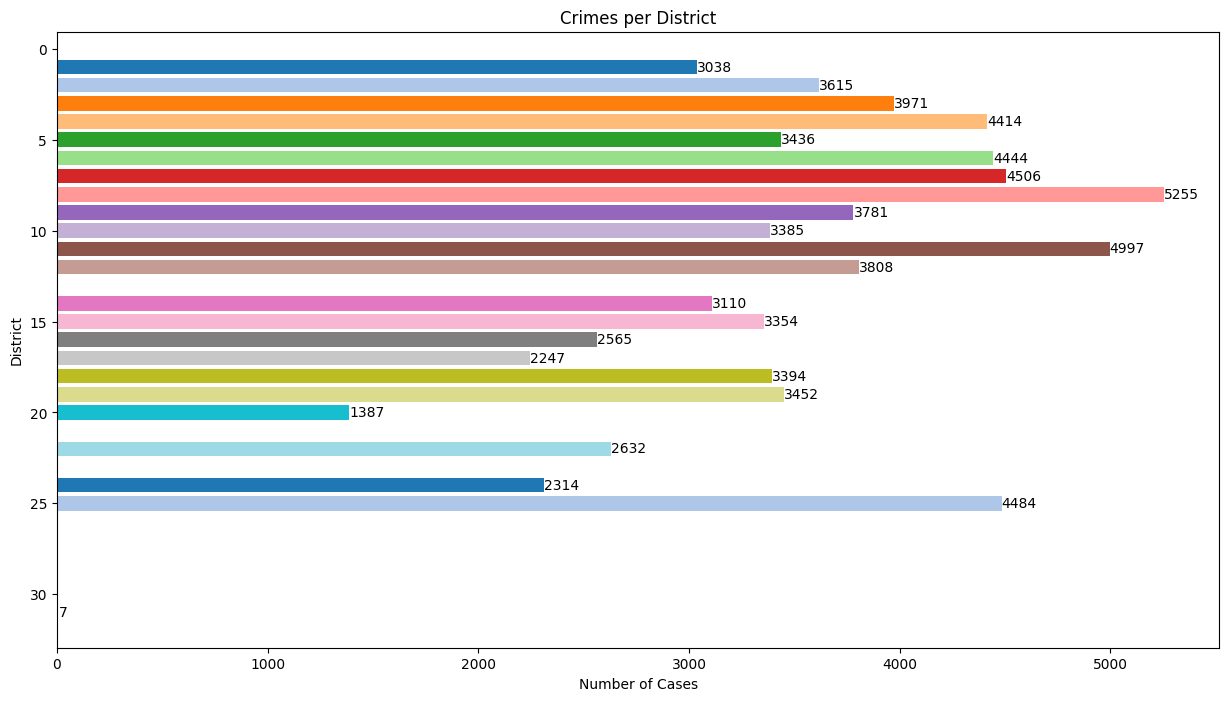

In [12]:
mycursor = conx.cursor()

crimes_by_dist = "select count(id) as crimes_count, district from crimes group by district order by district asc"
mycursor.execute(crimes_by_dist)

results = mycursor.fetchall()

mycursor.close()

crimes_per_district_df = pd.DataFrame(results, columns=['count', 'district'])

# print(crimes_per_district_df)

color = plt.cm.tab20.colors

plt.figure(figsize=(15, 8))
bars=plt.barh(crimes_per_district_df['district'], crimes_per_district_df['count'], color=color)
plt.xlabel('Number of Cases')
plt.ylabel('District') 
plt.title('Crimes per District')
plt.gca().invert_yaxis()  

for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{bar.get_width()}', 
             va='center', ha='left', fontsize=10)

plt.show()

##### In this subset, during the 23 years, the district with the highest amount of criminal cases was district 8 and the minimum that we have register was district 31. There are some districts with no crime, we consider that there is not enough prove to affirm that there wasn't crime in those parts of the city as we are working with the 0.01% of all the data. Still, we can observe a tendency of more cases between the districts 4 and 11. 

## Crimes per type of crime - TOP 10 (chart)

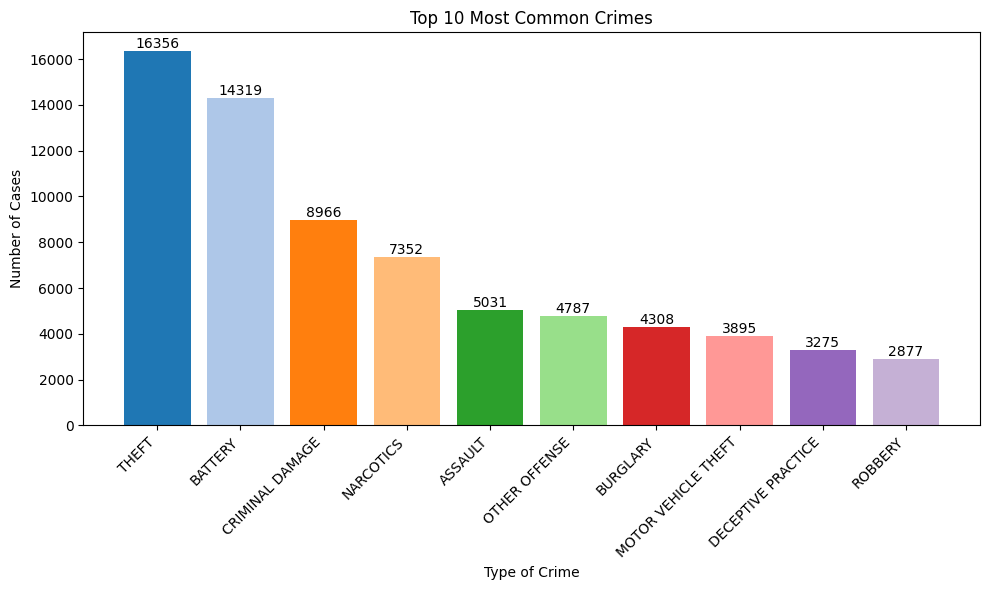

In [13]:
mycursor = conx.cursor()

top_crimes = "select primary_type, count(id) as count from crimes group by primary_type order by count desc limit 10"
mycursor.execute(top_crimes)

results = mycursor.fetchall()

mycursor.close()

top_10_crimes = pd.DataFrame(results, columns=['type', 'count'])

# print(top_10_crimes)

color = plt.cm.tab20.colors

plt.figure(figsize=(10, 6))
bars = plt.bar(top_10_crimes['type'], top_10_crimes['count'], color=color)
plt.ylabel('Number of Cases') 
plt.xlabel('Type of Crime') 
plt.title('Top 10 Most Common Crimes')
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() * 0.5, bar.get_height(),
             f'{bar.get_height():.0f}',
             va='bottom', ha='center', fontsize=10, color='black')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

##### The most commited crime in the city of Chicago from 2001 to 2023 was theft with more than 16000 cases, the less commited crime was robbery. The difference between theft and robbery is that in the second one it is used force. 

# Amount of crimes through time (chart)

date
2001-01-31    370
2001-02-28    400
2001-03-31    409
2001-04-30    418
2001-05-31    433
             ... 
2023-03-31    224
2023-04-30    245
2023-05-31    235
2023-06-30    203
2023-07-31     93
Freq: M, Length: 271, dtype: int64


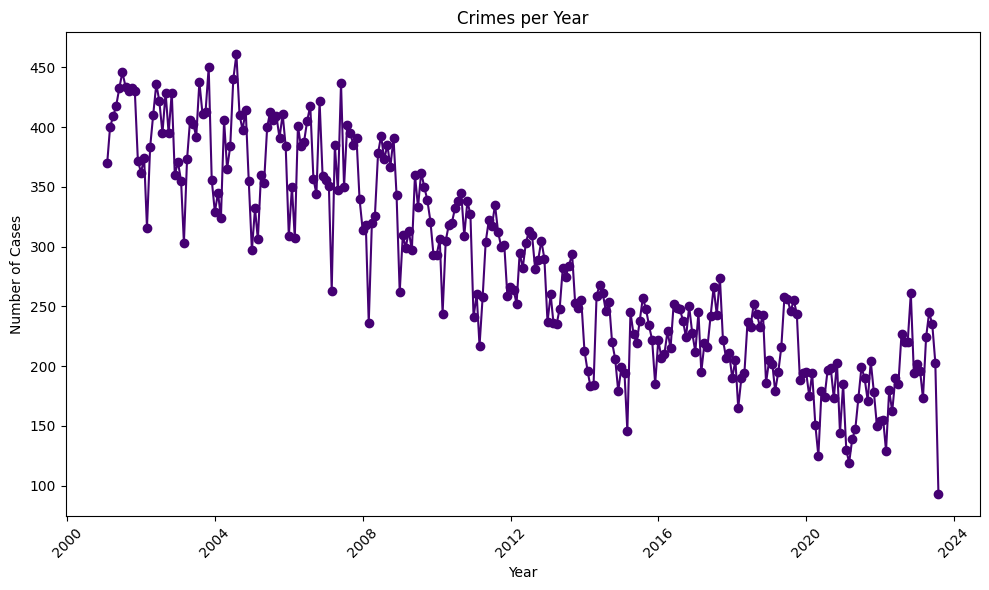

In [14]:
mycursor = conx.cursor()

all_info = "SELECT * from crimes"
mycursor.execute(all_info)

results = mycursor.fetchall()

mycursor.close()

df1 = pd.DataFrame(results, columns=['id', 'date', 'time', 'block', 'iucr', 'prymary_type', 'description', 'location_desc', 'arrest', 'district', 'year', 'updated_on', 'location'])

df1['date'] = pd.to_datetime(df1['date'])
crime_per_month = df1.resample("M"  , on = 'date').size()

print(crime_per_month)

plt.figure(figsize = (10,6))
plt.plot(crime_per_month.index , crime_per_month.values , marker = 'o', color = '#450073')
plt.xlabel("Year")
plt.ylabel("Number of Cases")
plt.title("Crimes per Year")
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

##### In this graphic we can see the behaviour of the amount of crimes through time. There is a tendency of reduction of cases while time passes by, and we can also observe a decrease during the period 2020 until the beginning of 2023. We can conclude that this is due to the pandemic, when people were in lockdown and there was less activity in the streets. To look at this insight more closely we can see this graphic:

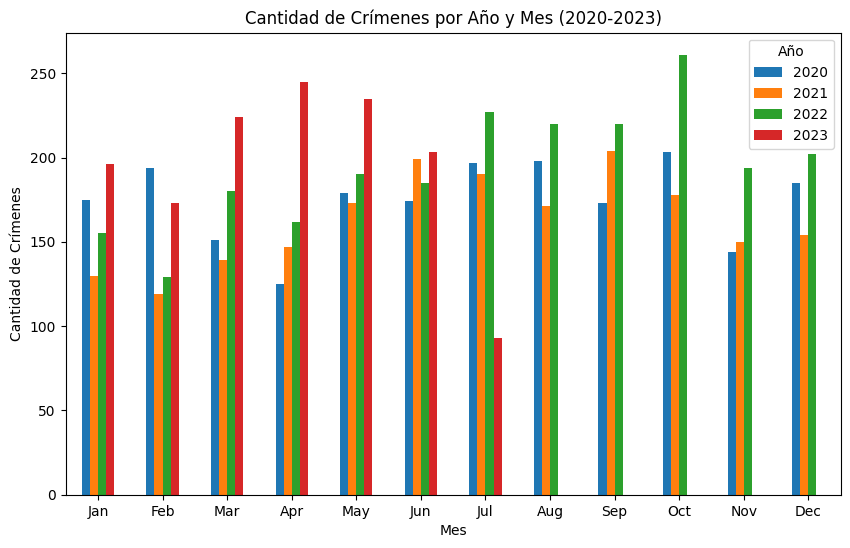

In [23]:
df1['year'] = df1['date'].dt.year
df1['month'] = df1['date'].dt.month

# Filtrar los años que te interesan (2020, 2021, 2022)
years_of_interest = [2020, 2021, 2022, 2023]
filtered_df = df1[df1['year'].isin(years_of_interest)]

# Agrupar por mes y año, contando la cantidad de crímenes en cada categoría
crime_per_month = filtered_df.groupby(['month', 'year']).size().unstack()

# Crear la gráfica de barras
crime_per_month.plot(kind='bar', figsize=(10, 6))
plt.title('Cantidad de Crímenes por Año y Mes (2020-2023)')
plt.xlabel('Mes')
plt.ylabel('Cantidad de Crímenes')
plt.xticks(rotation=0)
plt.xticks(range(0, 12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Año')
plt.show()

##### Comparing the amount of crimes in the beginning of the year between the years that were more affected by the pandemic and the current year 2023, we can see that there are lesscases, specially and the end of the year of 2020 and the first months of 2021.

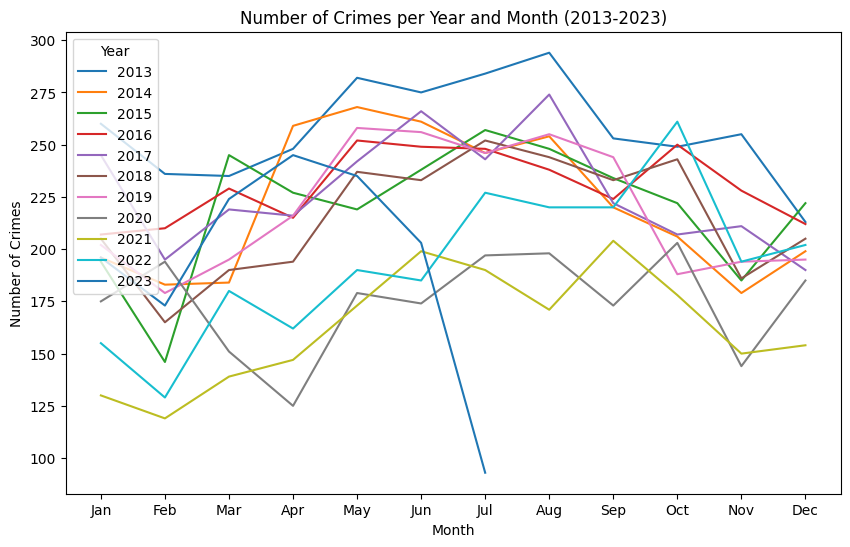

In [49]:
# Filter years between 2001 and 2023
years_of_interest = list(range(2013, 2024))
filtered_df = df1[df1['year'].isin(years_of_interest)]

# Group by month and year, counting the number of crimes in each category
crime_per_month = filtered_df.groupby(['month', 'year']).size().unstack()

# Create the line chart
crime_per_month.plot(kind='line', figsize=(10, 6))
plt.title('Number of Crimes per Year and Month (2013-2023)')
plt.xlabel('Month')
plt.ylabel('Number of Crimes')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Year', loc='upper left')
plt.show()

# Arrested or not (Chart)

   Arrest  count
0       1  20278
1       0  57318


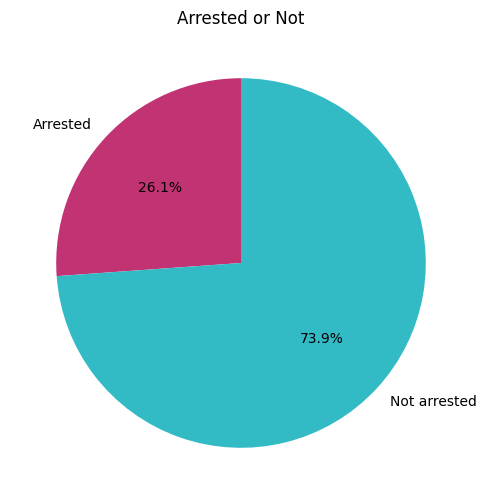

In [51]:
arrested_or_not = df1['arrest'].value_counts().sort_index(ascending=False)
arrested_or_not_df = arrested_or_not.reset_index()
arrested_or_not_df.columns = ['Arrest', 'count']
print(arrested_or_not_df)

arrested_or_not_df['Arrest'] = arrested_or_not_df['Arrest'].replace({1: 'Arrested', 0: 'Not arrested'})


plt.figure(figsize=(6, 6))
colors = ['#C23373', '#33BBC5']
plt.pie(arrested_or_not_df['count'], labels=arrested_or_not_df['Arrest'], colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Arrested or Not')

plt.show()

##### We can see that in most cases, the perpetrator of the crime was not arrested.

# Top 10 days with more cases (table)

In [52]:
num_cases_day = df1.groupby(['date'])['id'].count()

top_10_days = num_cases_day.sort_values(ascending=False).head(10).reset_index()
top_10_days = top_10_days.rename(columns={'id': 'case_count'})

top_10_days

,date,case_count
0,2001-07-26,26
1,2007-05-14,26
2,2001-02-27,25
3,2001-12-15,25
4,2002-01-11,25
5,2001-10-05,25
6,2007-04-23,24
7,2002-04-26,24
8,2006-10-24,24
9,2008-08-28,24


##### We can see in the top 10 of days with more crimes there are more days that belong to the year 2001 than in other years. Still, there is not a big difference between the amount of crimes, the value is between 24 and 26. In reality, if we use all the data (mre than 7 million rows), there is a big difference between the top 10 days with more crimes and the results have more sense and are more explanatory:


In [55]:
csv_file = "data/Crimes_2001_to_Present.csv"
df_total= pd.read_csv(csv_file)

In [60]:
df_total['Date'] = pd.to_datetime(df_total['Date'], format='%m/%d/%Y %I:%M:%S %p').dt.date


num_cases_day_total = df_total.groupby(['Date'])['ID'].count()

top_10_days_total = num_cases_day_total.sort_values(ascending=False).head(10).reset_index()
top_10_days_total = top_10_days_total.rename(columns={'id': 'case_count'})

top_10_days_total

,Date,ID
0,2003-01-01,2033
1,2005-01-01,1978
2,2007-01-01,1963
3,2006-01-01,1919
4,2020-05-31,1899
5,2004-01-01,1897
6,2002-01-01,1873
7,2009-01-01,1844
8,2001-01-01,1825
9,2008-01-01,1817


##### Using the whole dataset we can observe that the day with more crimes is the first of january, which makes sense as it is the day after new year and there is more people in the streets causing trouble. The only day that is not the first of the year is the 31st of may of 2020, which was a day with many protests against police brutality (black lives matter movement).

# Top 10 Location Descriptions with Highest Number of Cases (chart)

location_desc
STREET                            20385
RESIDENCE                         12727
APARTMENT                          8904
SIDEWALK                           7289
OTHER                              2649
PARKING LOT/GARAGE(NON.RESID.)     2014
ALLEY                              1724
SMALL RETAIL STORE                 1466
SCHOOL, PUBLIC, BUILDING           1456
RESIDENCE-GARAGE                   1395
Name: id, dtype: int64


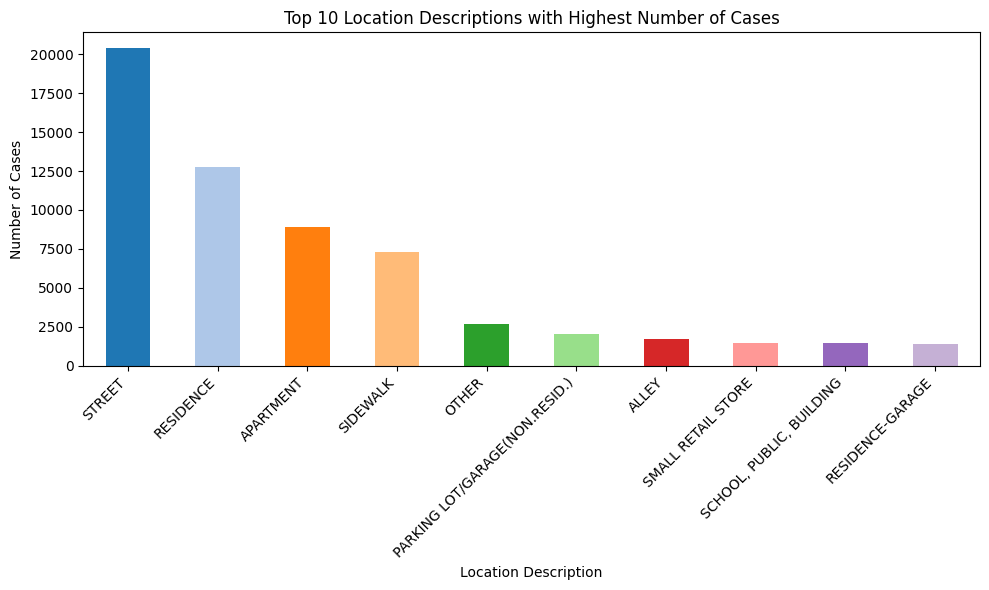

In [62]:
num_loc_desc = df1.groupby(['location_desc'])['id'].count()

location_desc = num_loc_desc.sort_values(ascending=False).head(10)

print(location_desc)


plt.figure(figsize=(10, 6))
location_desc.plot(kind='bar', color= color)
plt.xlabel('Location Description')
plt.ylabel('Number of Cases')
plt.title('Top 10 Location Descriptions with Highest Number of Cases')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

##### We can see that most crimes in Chicago were committed in the streets, and the second place with most cases  are residences. The places with less crimes are small retail stores, schools and residence's garages (which is a really specific place to commit a crime, that explains the small amount of crimes, it's not so usual).